## Analyses of clinical data and number of publications obtained from the [FMUG tool](https://fmug.amaral.northwestern.edu/)

This notebook reproduces Fig. 5, S8, and S9

Authors: Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [50]:
import numpy as np
import pandas as pd
import glob 
import time
import os
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, gaussian_kde, ttest_ind
from scipy.stats import binned_statistic, binned_statistic_2d
from ast import literal_eval
import seaborn as sns
from joblib import dump, load
from localcider.sequenceParameters import SequenceParameters
# function to calculate standard error of the mean
se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'

def plot_hist_variants(ax,df_idrome,intervals,xlabel,w=.6,
                      hatch='////',color=['tab:orange']*8+['tab:blue']*2+['tab:green']*4):
    
    mean_se = df_idrome.groupby(intervals).agg(['mean',se])
    mean_se.rename(columns={'n_benign': 'Benign', 'n_pathogenic':'Pathogenic'},
                   inplace=True)
    
    mean_se.xs('mean',axis=1,level=1).plot(rot=90, ax=ax, kind='bar', 
                    yerr=mean_se.xs('SE',axis=1,level=1),
                    width=w,zorder=1,
                    error_kw=dict(ecolor='black',elinewidth=0.5,capsize=1.5),
                    label='w/o del',hatch=hatch,color='w',
                    edgecolor=['tab:orange']*8+['tab:blue']*2+['tab:green']*4,legend=False)
    
    subset = mean_se.copy()
    subset.iloc[8:] = np.nan
    
    subset.xs('mean',axis=1,level=1).plot(rot=90, ax=ax, kind='bar', 
                    width=w,zorder=1,hatch=hatch,color=['tab:orange','w'],
                    edgecolor=['tab:orange']*8+['w']*5,legend=False)
    
    subset = mean_se.copy()
    subset.iloc[:8] = np.nan
    subset.iloc[10:] = np.nan
    
    subset.xs('mean',axis=1,level=1).plot(rot=90, ax=ax, kind='bar', 
                    width=w,zorder=1,hatch=hatch,color=['tab:blue','w'],
                    edgecolor=['w']*8+['tab:blue']*2+['w']*4,legend=False)
    
    subset = mean_se.copy()
    subset.iloc[:10] = np.nan
    
    subset.xs('mean',axis=1,level=1).plot(rot=90, ax=ax, kind='bar', 
                    width=w,zorder=1,hatch=hatch,color=['tab:green','w'],
                    edgecolor=['w']*10+['tab:green']*4,legend=False)
    
    ax.set_xlabel(xlabel)
    
def calc_seq_prop(df,r,name,model):
    features = ['scd','shd','kappa','fcr','mean_lambda']
    features_WT = ['scd_WT','shd_WT','kappa_WT','fcr_WT','mean_lambda_WT']
    
    fasta = list(df.loc[name].fasta).copy()
    fasta_WT = list(df.loc[name].fasta_WT).copy()
    fasta_kappa = fasta.copy()
    fasta_kappa_WT = fasta_WT.copy()
    
    N = len(fasta)
    N_WT = len(fasta_WT)
    
    df.loc[name,'mean_lambda'] = np.mean(r.loc[fasta].lambdas)
    df.loc[name,'mean_lambda_WT'] = np.mean(r.loc[fasta_WT].lambdas)
    
    #########
    
    pairs = np.array(list(itertools.combinations(fasta,2)))
    pairs_indices = np.array(list(itertools.combinations(range(N),2)))
    # calculate sequence separations
    ij_dist = np.diff(pairs_indices,axis=1).flatten().astype(float)
    # calculate lambda sums
    ll = r.lambdas.loc[pairs[:,0]].values+r.lambdas.loc[pairs[:,1]].values
    # calculate SHD
    beta = -1
    df.loc[name,'shd'] = np.sum(ll*np.power(np.abs(ij_dist),beta))/N
    
    # fix charges
    if df.loc[name,'N_term'] == True:
        r.loc['X'] = r.loc[fasta[0]]
        r.loc['X','q'] = r.loc[fasta[0],'q'] + 1.
        fasta[0] = 'X'
        if r.loc['X','q'] > 0:
            fasta_kappa[0] = 'K'
        else:
            fasta_kappa[0] = 'A'
    if df.loc[name,'C_term'] == True:
        r.loc['Z'] = r.loc[fasta[-1]]
        r.loc['Z','q'] = r.loc[fasta[-1],'q'] - 1.
        fasta[-1] = 'Z'
        if r.loc['Z','q'] < 0:
            fasta_kappa[-1] = 'D'
        else:
            fasta_kappa[-1] = 'A'
    
    pairs = np.array(list(itertools.combinations(fasta,2)))
    # calculate charge products
    qq = r.q.loc[pairs[:,0]].values*r.q.loc[pairs[:,1]].values
    # calculate SCD
    df.loc[name,'scd'] = np.sum(qq*np.sqrt(ij_dist))/N
    SeqOb = SequenceParameters(''.join(fasta_kappa))
    kappa = SeqOb.get_kappa()
    df.loc[name,'kappa'] = 0 if kappa==-1 else kappa
    df.loc[name,'fcr'] = r.q.loc[list(fasta)].abs().mean()
    df.loc[name,'ncpr'] = r.q.loc[list(fasta)].mean()
    
    #########
    
    pairs = np.array(list(itertools.combinations(fasta_WT,2)))
    pairs_indices = np.array(list(itertools.combinations(range(N_WT),2)))
    # calculate sequence separations
    ij_dist = np.diff(pairs_indices,axis=1).flatten().astype(float)
    # calculate lambda sums
    ll = r.lambdas.loc[pairs[:,0]].values+r.lambdas.loc[pairs[:,1]].values
    # calculate SHD
    beta = -1
    df.loc[name,'shd_WT'] = np.sum(ll*np.power(np.abs(ij_dist),beta))/N_WT
    
    # fix charges
    if df.loc[name,'N_term'] == True:
        r.loc['X'] = r.loc[fasta_WT[0]]
        r.loc['X','q'] = r.loc[fasta_WT[0],'q'] + 1.
        fasta_WT[0] = 'X'
        if r.loc['X','q'] > 0:
            fasta_kappa_WT[0] = 'K'
        else:
            fasta_kappa_WT[0] = 'A'
    if df.loc[name,'C_term'] == True:
        r.loc['Z'] = r.loc[fasta_WT[-1]]
        r.loc['Z','q'] = r.loc[fasta_WT[-1],'q'] - 1.
        fasta_WT[-1] = 'Z'
        if r.loc['Z','q'] < 0:
            fasta_kappa_WT[-1] = 'D'
        else:
            fasta_kappa_WT[-1] = 'A'
    
    pairs = np.array(list(itertools.combinations(fasta_WT,2)))
    # calculate charge products
    qq = r.q.loc[pairs[:,0]].values*r.q.loc[pairs[:,1]].values
    # calculate SCD
    df.loc[name,'scd_WT'] = np.sum(qq*np.sqrt(ij_dist))/N
    SeqOb = SequenceParameters(''.join(fasta_kappa_WT))
    kappa = SeqOb.get_kappa()
    df.loc[name,'kappa_WT'] = 0 if kappa==-1 else kappa
    df.loc[name,'fcr_WT'] = r.q.loc[list(fasta_WT)].abs().mean()
    df.loc[name,'ncpr_WT'] = r.q.loc[list(fasta_WT)].mean()
            
    df.loc[name,'nu'] = model.predict(df.loc[name,features].values.reshape(1, -1))
    df.loc[name,'nu_WT'] = model.predict(df.loc[name,features_WT].values.reshape(1, -1))

#### Generate sequences of missense variants from ClinVar

In [51]:
# Load dataframes
df_variants = pd.DataFrame()
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
r = pd.read_csv('md_simulations/data/residues.csv').set_index('one',drop=False)
clinvar_info = pd.read_csv('clinvar_fmug/data/idr_fragments_clinvar_info.csv',index_col='idr_fragment')
clinvar_info.Clinvar_ID = clinvar_info.Clinvar_ID.apply(lambda x: literal_eval(x))
clinvar_info.Clinvar_signifiance = clinvar_info.Clinvar_signifiance.apply(lambda x: literal_eval(x))
clinvar_info.variants = clinvar_info.variants.apply(lambda x: literal_eval(x))
clinvar_info.drop('membrane_protein',axis=1,inplace=True)
clinvar_info = clinvar_info.groupby('idr_fragment').sum()

# Load pLDDT scores
pLDDT = pd.read_csv('idr_selection/idr_pLDDT.csv.gz',header=0,sep=';')
pLDDT.sort_values('uniprot',inplace=True)
pLDDT['seq_name'] = pLDDT.uniprot+'_'+pLDDT['first'].apply(
    lambda x : '{:g}'.format(x))+'_'+pLDDT['last'].apply(lambda x : '{:g}'.format(x))
pLDDT['pLDDT_w20'] = pLDDT['pLDDT_w20'].apply(lambda x : 100*np.array(eval(x.replace(':',','))))
pLDDT.set_index('seq_name',inplace=True)

# Generate dataframe with sequences of variants
idrs_w_variants = clinvar_info[clinvar_info.variants.map(len)>0].index
for name in idrs_w_variants:
    fasta_WT = df_idrome.loc[name].fasta
    for x,s in zip(clinvar_info.loc[name,'variants'],clinvar_info.loc[name,'Clinvar_signifiance']):
        fasta_var = fasta_WT
        res_num_var = int(x[1:-1])-df_idrome.loc[name,'first']
        fasta_var = fasta_WT[:res_num_var] + x[-1] + fasta_WT[res_num_var+1:]
        df_variants.loc[name+'_'+x,'fasta'] = fasta_var
        df_variants.loc[name+'_'+x,'fasta_WT'] = fasta_WT
        df_variants.loc[name+'_'+x,'significance'] = s
        df_variants.loc[name+'_'+x,'WT'] = name
        df_variants.loc[name+'_'+x,'pLDDT'] = pLDDT.loc[name,'pLDDT_w20'][res_num_var]
        df_variants.loc[name+'_'+x,'fdomain'] = df_idrome.loc[name,'fdomain']
        df_variants.loc[name+'_'+x,'N_term'] = df_idrome.loc[name,'N_term']
        df_variants.loc[name+'_'+x,'C_term'] = df_idrome.loc[name,'C_term']

#### Calculate Flory scaling exponents for WT and variants using the SVR model

In [52]:
model = load('svr_model/svr_model.joblib') 

In [53]:
if not os.path.isfile('clinvar_fmug/data/missense_variants.csv.gz'):
    for ndx in df_variants.index:
        calc_seq_prop(df_variants,r,ndx,model)
    df_variants['Delta_nu'] = df_variants['nu'] - df_variants['nu_WT']
    df_variants.to_csv('clinvar_fmug/data/missense_variants.csv.gz')
else:
    df_variants = pd.read_csv('clinvar_fmug/data/missense_variants.csv.gz',index_col=0)

#### Count benign and pathogenic variants per IDR

In [54]:
df_idrome['n_benign'] = clinvar_info.Clinvar_signifiance.apply(lambda x: x.count('benign'))
df_idrome['n_pathogenic'] = clinvar_info.Clinvar_signifiance.apply(lambda x: x.count('pathogenic'))

#### Extract number of publications per gene from FMUG

In [55]:
gene_n_pubs = pd.read_csv('clinvar_fmug/data/fmug_data.csv.gz',index_col=0).n_pubs
df_idrome['n_pubs'] = df_idrome.gene_name.apply(lambda x : gene_n_pubs[x] if x in gene_n_pubs.index else 0)

#### Fig. 4

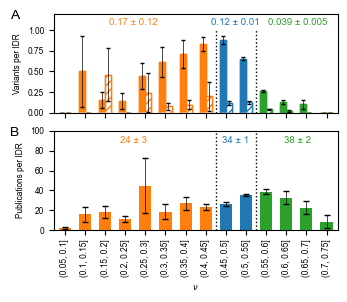

In [56]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(3.4,3))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

#df_idrome['clinvar_benign_wodel'] = df_idrome['clinvar_benign_wodel']/df_idrome.N
#df_idrome['clinvar_pathogenic_wodel'] = df_idrome['clinvar_pathogenic_wodel']/df_idrome.N

# bin nu values
intervals = pd.cut(df_idrome['nu'], np.arange(0.05, .76, .05))
plot_hist_variants(ax1,df_idrome[['n_benign','n_pathogenic']],
                  intervals,xlabel=r'$\nu$')
ax1.set_xlim(3.5,13.5)

ax1.vlines([7.5,9.5],ymin=0,ymax=1,color='k',ls=':',lw=1)
ax1.set_ylim(0,1.2)

intervals = pd.cut(df_idrome['nu'], np.array([0, .45, .55, .8]))
mean_std = df_idrome['n_pathogenic'].groupby(intervals).agg(['mean',se])

n_compact = mean_std.iloc[0]['mean']
n_theta = mean_std.iloc[1]['mean']
n_expanded = mean_std.iloc[-1]['mean']
n_compact_e = mean_std.iloc[0]['SE']
n_theta_e = mean_std.iloc[1]['SE']
n_expanded_e = mean_std.iloc[-1]['SE']

ax1.annotate(f'{n_compact:.2f} ± {n_compact_e:.2f}',xy=(.28,.88),
            xycoords='axes fraction',color='tab:orange',fontsize=7,ha='center')
ax1.annotate(f'{n_theta:.2f} ± {n_theta_e:.2f}',xy=(.64,.88),
            xycoords='axes fraction',color='tab:blue',fontsize=7,ha='center')
ax1.annotate(f'{n_expanded:.3f} ± {n_expanded_e:.3f}',xy=(.86,.88),
            xycoords='axes fraction',color='tab:green',fontsize=7,ha='center')

ax1.set_ylabel(r'Variants per IDR')

##################

intervals = pd.cut(df_idrome['nu'], np.arange(0.05, .76, .05))
mean_std = df_idrome['n_pubs'].groupby(intervals).agg(['mean',se])
mean_std['mean'].plot(rot=90, ax=ax2, kind='bar', yerr=mean_std['SE'],
                      error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2),
                      color=['tab:orange']*8+['tab:blue']*2+['tab:green']*4,width=.6)

intervals = pd.cut(df_idrome['nu'], np.array([0, .45, .55, .8]))
mean_std = df_idrome['n_pubs'].groupby(intervals).agg(['mean',se])

n_compact = mean_std.iloc[0]['mean']
n_theta = mean_std.iloc[1]['mean']
n_expanded = mean_std.iloc[-1]['mean']
n_compact_e = mean_std.iloc[0]['SE']
n_theta_e = mean_std.iloc[1]['SE']
n_expanded_e = mean_std.iloc[-1]['SE']

ax2.vlines([7.5,9.5],ymin=0,ymax=100,color='k',ls=':',lw=1)
ax2.set_ylim(0,100)

ax2.annotate(f'{n_compact:.0f} ± {n_compact_e:.0f}',xy=(.28,.88),
            xycoords='axes fraction',color='tab:orange',fontsize=7,ha='center')
ax2.annotate(f'{n_theta:.0f} ± {n_theta_e:.0f}',xy=(.64,.88),
            xycoords='axes fraction',color='tab:blue',fontsize=7,ha='center')
ax2.annotate(f'{n_expanded:.0f} ± {n_expanded_e:.0f}',xy=(.86,.88),
            xycoords='axes fraction',color='tab:green',fontsize=7,ha='center')

ax2.set_ylabel(r'Publications per IDR')
ax2.set_xlabel(r'$\nu$')

fig.text(0.01, .94, 'A', fontsize=10)
fig.text(0.01, .55, 'B', fontsize=10)

plt.tight_layout()
fig.savefig('figs/fig5.pdf')

#### Perform two-tailed Welch’s t-test

In [57]:
benign_pLDDT = df_variants.query("significance == 'benign'").pLDDT.values
pathogenic_pLDDT = df_variants.query("significance == 'pathogenic'").pLDDT.values
ttest_ind(benign_pLDDT,pathogenic_pLDDT,equal_var=False,alternative='two-sided')

Ttest_indResult(statistic=-31.372853250880823, pvalue=6.99933267576661e-193)

#### Perform two-tailed Welch’s t-test excluding IDRs with folded domains

In [58]:
benign_pLDDT = df_variants.query("fdomain == 0 and significance == 'benign'").pLDDT.values
pathogenic_pLDDT = df_variants.query("fdomain == 0 and significance == 'pathogenic'").pLDDT.values
ttest_ind(benign_pLDDT,pathogenic_pLDDT,equal_var=False,alternative='two-sided')

Ttest_indResult(statistic=-19.03682306675205, pvalue=2.344894439347788e-76)

#### Fig. S8

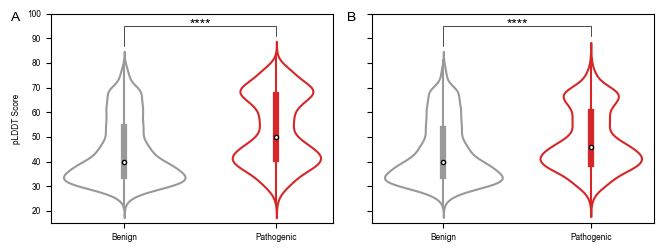

In [59]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(6.6,2.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

benign_pLDDT = df_variants.query("significance == 'benign' and fdomain == 0").pLDDT.values
pathogenic_pLDDT = df_variants.query("significance == 'pathogenic' and fdomain == 0").pLDDT.values


sns.violinplot(ax=ax1,data=df_variants[['significance','pLDDT']],
            x='significance',y='pLDDT',color='w',inner='box')

sns.violinplot(ax=ax2,
            data=df_variants.query('fdomain == 0')[['significance','pLDDT']],
            x='significance',y='pLDDT',color='w',inner='box')

for ax in [ax1,ax2]:
    ax.plot([0, 0, 1, 1], [87, 95, 95, 91], lw=.5, c='k')
    ax.text(.5, 93, '****', ha='center', va='bottom', color='k', fontsize=10)
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Benign','Pathogenic'])
    ax.set_xlabel('')
    ax.set_ylim(15,100)
    ax.collections[1].set_edgecolor('k')
    ax.collections[2].set_edgecolor('tab:red')
    ax.collections[3].set_edgecolor('k')
    
    ax.get_children()[5].set_color('tab:red') 
    ax.get_children()[6].set_color('tab:red')

ax1.set_ylabel('pLDDT Score')
ax2.set_ylabel('')

fig.text(0.01, .92, 'A', fontsize=10)
fig.text(0.52, .92, 'B', fontsize=10)

plt.tight_layout(w_pad=4)

plt.savefig('figs/figS8.pdf',dpi=300)

#### Analysis of frameshift variants in C-terminal IDRs identified by Mensah et al. (DOI: 10.1038/s41586-022-05682-1)
The list of variants with ClinVar significance annotations were obtained from https://zenodo.org/record/7311150/files/MasterTable_wNMD_wVariantDisease_wRK_WHidrophobic_wNLS_wTransmembrane_220608_Full.csv.zip

In [60]:
url = """https://zenodo.org/record/7311150/files/MasterTable_wNMD_wVariantDisease_
wRK_WHidrophobic_wNLS_wTransmembrane_220608_Full.csv.zip""".replace('\n','')

#### Load table and select IDRs with WT and variant sequence lengths $\geq30$

In [61]:
df_frameshift = pd.read_csv(url, low_memory=False)
df_frameshift = df_frameshift.query('SeqType == "Frameshift"')
df_frameshift = df_frameshift.rename({'IDRseq':'fasta',
                      'WTIDRseq':'fasta_WT'},axis=1)
df_frameshift['N_WT'] = df_frameshift.fasta_WT.apply(len)
df_frameshift['N'] = df_frameshift.fasta.apply(len)
df_frameshift = df_frameshift.query('N >= 30 and N_WT >= 30')
df_frameshift['N_term'] = df_frameshift['TrueIDRstart'].apply(lambda x: True if x == 1 else False)
df_frameshift['C_term'] = True

#### Calculate Flory scaling exponents for WT and variants using the SVR model

In [68]:
if not os.path.isfile('clinvar_fmug/data/frameshift_variants.csv.gz'):
    for ndx in df_frameshift.index:
        calc_seq_prop(df_frameshift,r,ndx,model)
    df_frameshift['Delta_nu'] = df_frameshift['nu'] - df_frameshift['nu_WT']
    df_frameshift.to_csv('clinvar_fmug/data/frameshift_variants.csv.gz')
else:
    df_frameshift = pd.read_csv('clinvar_fmug/data/frameshift_variants.csv.gz',index_col=0)

#### Fig. S9

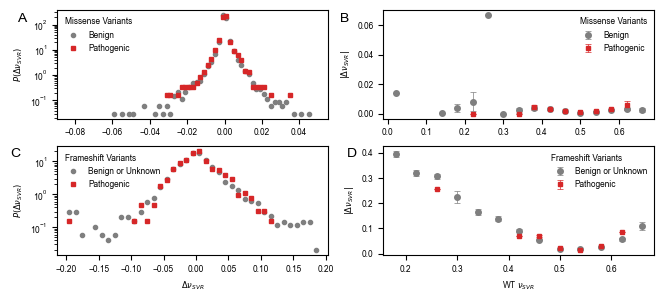

In [69]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(6.6,3))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

bins = np.arange(-0.084,0.051,.002)
x = bins[:-1]+(bins[1]-bins[0])/2.

h,_ = np.histogram(df_variants.query("significance == 'benign'").Delta_nu.values,
                   bins=bins,density=True)
ax1.plot(x,h,lw=0,color='tab:gray',marker='o',ms=3,label='Benign')

h,_ = np.histogram(df_variants.query("significance == 'pathogenic'").Delta_nu.values,
                   bins=bins,density=True)
ax1.plot(x,h,lw=0,color='tab:red',marker='s',ms=3,label='Pathogenic')

ax1.set_yscale('log')
#ax1.set_xlim(-.04,0.03)

ax1.set_ylabel('$P(\\Delta \\nu_{SVR})$')

bins = np.arange(0, .701, .04)
x = bins[:-1]+(bins[1]-bins[0])/2.

average = binned_statistic(df_variants.query("significance == 'benign'").nu_WT.values,
                           np.abs(df_variants.query("significance == 'benign'").Delta_nu.values),bins=bins)[0]
standard_error = binned_statistic(df_variants.query("significance == 'benign'").nu_WT.values,
                           np.abs(df_variants.query("significance == 'benign'").Delta_nu.values),
                           statistic=se,
                                 bins=bins)[0]

ax2.errorbar(x,average,yerr=standard_error,ms=4,marker='o',lw=0,zorder=0,
         elinewidth=.5,capsize=2,capthick=.5,label='Benign',color='tab:gray')

average = binned_statistic(df_variants.query("significance == 'pathogenic'").nu_WT.values,
                           np.abs(df_variants.query("significance == 'pathogenic'").Delta_nu.values),bins=bins)[0]
standard_error = binned_statistic(df_variants.query("significance == 'pathogenic'").nu_WT.values,
                           np.abs(df_variants.query("significance == 'pathogenic'").Delta_nu.values),
                           statistic=se,
                                 bins=bins)[0]

ax2.errorbar(x,average,yerr=standard_error,ms=3,marker='s',lw=0,zorder=0,
         elinewidth=.5,capsize=2,capthick=.5,label='Pathogenic',color='tab:red')

ax2.set_ylabel('$|\\Delta \\nu_{SVR}|$')

leg = ax1.legend(frameon=False,title='Missense Variants',loc='upper left')
leg._legend_box.align = "left"
leg = ax2.legend(frameon=False,title='Missense Variants')
leg._legend_box.align = "left"

########

bins = np.arange(-0.2,0.2,.01)
x = bins[:-1]+(bins[1]-bins[0])/2.

h,_ = np.histogram(df_frameshift.query('Pathogenic == False').Delta_nu.values,
                   bins=bins,density=True)
ax3.plot(x,h,lw=0,color='tab:gray',marker='o',ms=3,label='Benign or Unknown')

h,_ = np.histogram(df_frameshift.query('Pathogenic == True').Delta_nu.values,
                   bins=bins,density=True)
ax3.plot(x,h,lw=0,color='tab:red',marker='s',ms=3,label='Pathogenic')

ax3.set_yscale('log')
#ax1.set_xlim(-.04,0.03)

ax3.set_xlabel('$\\Delta \\nu_{SVR}$')
ax3.set_ylabel('$P(\\Delta \\nu_{SVR})$')

bins = np.arange(0, .701, .04)
x = bins[:-1]+(bins[1]-bins[0])/2.

average = binned_statistic(df_frameshift.query('Pathogenic == False').nu_WT.values,
                           np.abs(df_frameshift.query('Pathogenic == False').Delta_nu.values),bins=bins)[0]
standard_error = binned_statistic(df_frameshift.query('Pathogenic == False').nu_WT.values,
                           np.abs(df_frameshift.query('Pathogenic == False').Delta_nu.values),
                           statistic=se,
                                 bins=bins)[0]

ax4.errorbar(x,average,yerr=standard_error,ms=4,marker='o',lw=0,zorder=0,
         elinewidth=.5,capsize=2,capthick=.5,label='Benign or Unknown',color='tab:gray')

average = binned_statistic(df_frameshift.query('Pathogenic == True').nu_WT.values,
                           np.abs(df_frameshift.query('Pathogenic == True').Delta_nu.values),bins=bins)[0]
standard_error = binned_statistic(df_frameshift.query('Pathogenic == True').nu_WT.values,
                           np.abs(df_frameshift.query('Pathogenic == True').Delta_nu.values),
                           statistic=se,
                                 bins=bins)[0]

ax4.errorbar(x,average,yerr=standard_error,ms=3,marker='s',lw=0,zorder=0,
         elinewidth=.5,capsize=2,capthick=.5,label='Pathogenic',color='tab:red')

ax4.set_ylabel('$|\\Delta \\nu_{SVR}|$')
ax4.set_xlabel('WT $\\nu_{SVR}$')

leg = ax3.legend(frameon=False,title='Frameshift Variants',loc='upper left')
leg._legend_box.align = "left"
leg = ax4.legend(frameon=False,title='Frameshift Variants')
leg._legend_box.align = "left"

fig.text(0.02, .93, 'A', fontsize=10)
fig.text(0.51, .93, 'B', fontsize=10)
fig.text(0.01, .48, 'C', fontsize=10)
fig.text(0.52, .48, 'D', fontsize=10)

plt.tight_layout()

plt.savefig('figs/figS9.pdf',dpi=300)

#### Print statistics on analysed missense variants

In [64]:
print('Number of variants',df_variants.shape[0])
print('Number of pathogenic variants',df_variants.query('significance == "pathogenic"').shape[0])
print('Number of benign variants',df_variants.query('significance == "benign"').shape[0])
print('Number of IDRs',df_variants.WT.unique().size)
print('Number of proteins',df_idrome.loc[df_variants.WT].UniProt_ID.unique().size)

Number of variants 19867
Number of pathogenic variants 2977
Number of benign variants 16890
Number of IDRs 7001
Number of proteins 4334


#### Print statistics on analysed frameshift variants

In [65]:
print('Number of variants',df_frameshift.shape[0])
print('Number of pathogenic variants',df_frameshift.query('Pathogenic == True').shape[0])
print('Number of benign variants',df_frameshift.query('Pathogenic == False').shape[0])
print('Number of IDRs',df_frameshift.fasta_WT.unique().size)
print('Number of proteins',df_frameshift.Gene.unique().size)

Number of variants 5676
Number of pathogenic variants 637
Number of benign variants 5039
Number of IDRs 2273
Number of proteins 2280
